# GradCAM - Gradient Class Activation Map

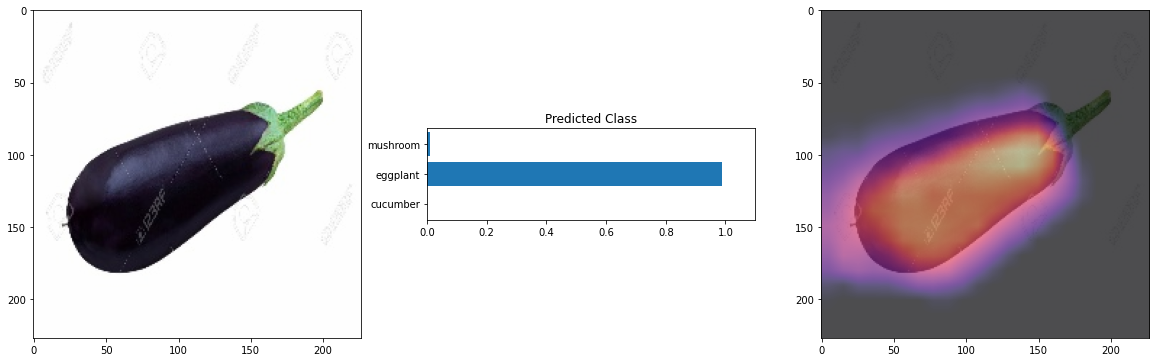

In [2]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!pip install albucore==0.0.23
!pip install -U albumentations

fatal: destination path 'GradCAM-Dataset' already exists and is not an empty directory.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-t2tsmt8s
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-t2tsmt8s
  Resolved https://github.com/albumentations-team/albumentations to commit 190ce313a143689e59ca727f799b729078a89285
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24


# Imports

In [3]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [5]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16

LR = 0.001
EPOCHS = 20

In [6]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [7]:
# cucumber - 0, eggplant - 1, mushroom - 2

train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

# Augmentations

In [8]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])


valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])


# Load Image Dataset

In [9]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = DATA_DIR)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir = DATA_DIR)

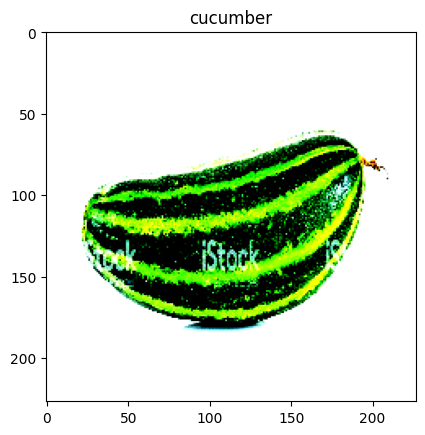

In [17]:
image, label = validset[22] # (c, h, w) -> (h, w, c)

class_list = ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label]);

In [15]:
print(f"No. of examples in the trainset {len(trainset)}")
print(f"No. of examples in the validset {len(validset)}")

No. of examples in the trainset 148
No. of examples in the validset 38


# Load Dataset into Batches

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [20]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

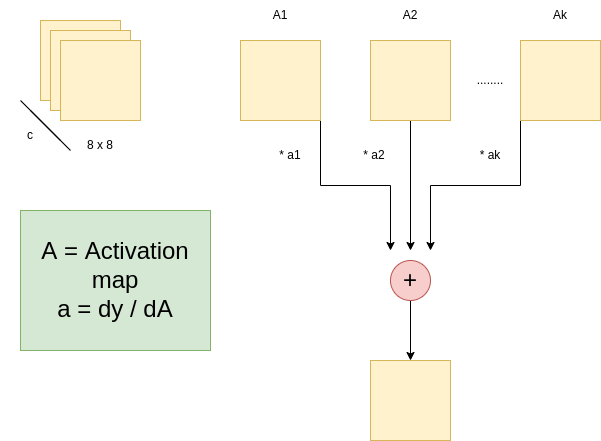

In [29]:
class ImageModel(nn.Module):

  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4, 4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4, 4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4, 4), stride = 2),

        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5,5), padding = 1),
        nn.ReLU(), #
    )

    self.maxpool = nn.MaxPool2d(kernel_size = (4, 4), stride = 2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048, 3)
    )

    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):

    x = self.feature_extractor(images)   #activation_maps

    h = x.register_hook(self.activations_hook)

    x = self.maxpool(x)
    x = self.classifier(x)

    return x

  def get_activation_gradients(self):  # a1, a2, a3...ak
    return self.gradient

  def get_activation(self, x):   # A1, A2, A3,     AK
    return self.feature_extractor(x)  # 64 * 8 * 8


In [30]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [31]:
def train_fn(dataloader, model, optimizer, criterion):

  model.train()
  total_loss = 0.0

  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [32]:
def eval_fn(dataloader, model, criterion):

  model.eval()
  total_loss = 0.0

  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(images)
    loss = criterion(logits, labels)

    total_loss += loss.item()

  return total_loss / len(dataloader)

# Training Loop

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = torch.nn.CrossEntropyLoss()

In [34]:
best_valid_loss = np.inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print('SAVED WEIGHTS SUCCESS')

  print(f"EPOCH : {i+1}  TRAIN LOSS : {train_loss}  VALID LOSS : {valid_loss}")


100%|██████████| 3/3 [00:00<00:00, 40.45it/s]


SAVED WEIGHTS SUCCESS
EPOCH : 1  TRAIN LOSS : 1.2394962191581727  VALID LOSS : 1.0961551666259766


100%|██████████| 3/3 [00:00<00:00, 43.37it/s]


SAVED WEIGHTS SUCCESS
EPOCH : 2  TRAIN LOSS : 1.0671021580696105  VALID LOSS : 0.9356576800346375


100%|██████████| 3/3 [00:00<00:00, 42.01it/s]


SAVED WEIGHTS SUCCESS
EPOCH : 3  TRAIN LOSS : 0.6954975575208664  VALID LOSS : 0.6243491371472677


100%|██████████| 3/3 [00:00<00:00, 45.58it/s]


EPOCH : 4  TRAIN LOSS : 0.6948191404342652  VALID LOSS : 0.884294812877973


100%|██████████| 3/3 [00:00<00:00, 40.56it/s]


SAVED WEIGHTS SUCCESS
EPOCH : 5  TRAIN LOSS : 0.4536638420075178  VALID LOSS : 0.5757640153169632


100%|██████████| 3/3 [00:00<00:00, 26.79it/s]


SAVED WEIGHTS SUCCESS
EPOCH : 6  TRAIN LOSS : 0.38297902047634125  VALID LOSS : 0.28243427475293476


100%|██████████| 3/3 [00:00<00:00, 28.78it/s]


SAVED WEIGHTS SUCCESS
EPOCH : 7  TRAIN LOSS : 0.1243690311908722  VALID LOSS : 0.2580980559190114


100%|██████████| 3/3 [00:00<00:00, 42.16it/s]


EPOCH : 8  TRAIN LOSS : 0.2879844875074923  VALID LOSS : 0.26792095477382344


100%|██████████| 3/3 [00:00<00:00, 38.42it/s]


EPOCH : 9  TRAIN LOSS : 0.24318439811468123  VALID LOSS : 0.2908937906225522


100%|██████████| 3/3 [00:00<00:00, 38.49it/s]


SAVED WEIGHTS SUCCESS
EPOCH : 10  TRAIN LOSS : 0.13698652852326632  VALID LOSS : 0.2470685097699364


100%|██████████| 3/3 [00:00<00:00, 39.46it/s]


EPOCH : 11  TRAIN LOSS : 0.10728511631023138  VALID LOSS : 0.431824525197347


100%|██████████| 3/3 [00:00<00:00, 38.33it/s]


EPOCH : 12  TRAIN LOSS : 0.4068847935646772  VALID LOSS : 0.3643740514914195


100%|██████████| 3/3 [00:00<00:00, 37.15it/s]


SAVED WEIGHTS SUCCESS
EPOCH : 13  TRAIN LOSS : 0.26505441069602964  VALID LOSS : 0.12303256740172704


100%|██████████| 3/3 [00:00<00:00, 39.33it/s]


EPOCH : 14  TRAIN LOSS : 0.17346044350415468  VALID LOSS : 0.25566327944397926


100%|██████████| 3/3 [00:00<00:00, 41.64it/s]


EPOCH : 15  TRAIN LOSS : 0.10158452829346061  VALID LOSS : 0.17075363802723587


100%|██████████| 3/3 [00:00<00:00, 39.01it/s]


EPOCH : 16  TRAIN LOSS : 0.04131060609943234  VALID LOSS : 0.458520104487737


100%|██████████| 3/3 [00:00<00:00, 38.93it/s]


EPOCH : 17  TRAIN LOSS : 0.08966740486212074  VALID LOSS : 0.35658160752306384


100%|██████████| 3/3 [00:00<00:00, 38.72it/s]


SAVED WEIGHTS SUCCESS
EPOCH : 18  TRAIN LOSS : 0.14902948892413406  VALID LOSS : 0.1046971728404363


100%|██████████| 3/3 [00:00<00:00, 39.25it/s]


SAVED WEIGHTS SUCCESS
EPOCH : 19  TRAIN LOSS : 0.08764165099710226  VALID LOSS : 0.0671071782708168


100%|██████████| 3/3 [00:00<00:00, 38.88it/s]

EPOCH : 20  TRAIN LOSS : 0.12191722844727337  VALID LOSS : 0.5463783045609792


# Get GradCAM

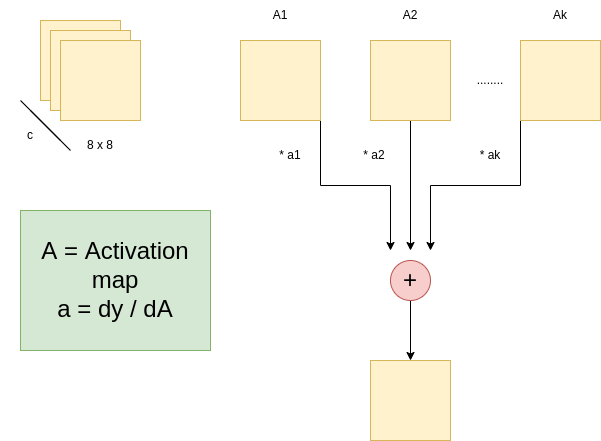

In [42]:
def get_gradcam(model, image, label, size):

  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim = [0, 2, 3]) # a1, a2, ....ak
  activations = model.get_activation(image).detach() # A1, A2, .....Ak

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap



In [37]:
# cucumber - 0, eggplant - 1, mushroom - 2

<ipython-input-47-a6a6f4a9b385>:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))


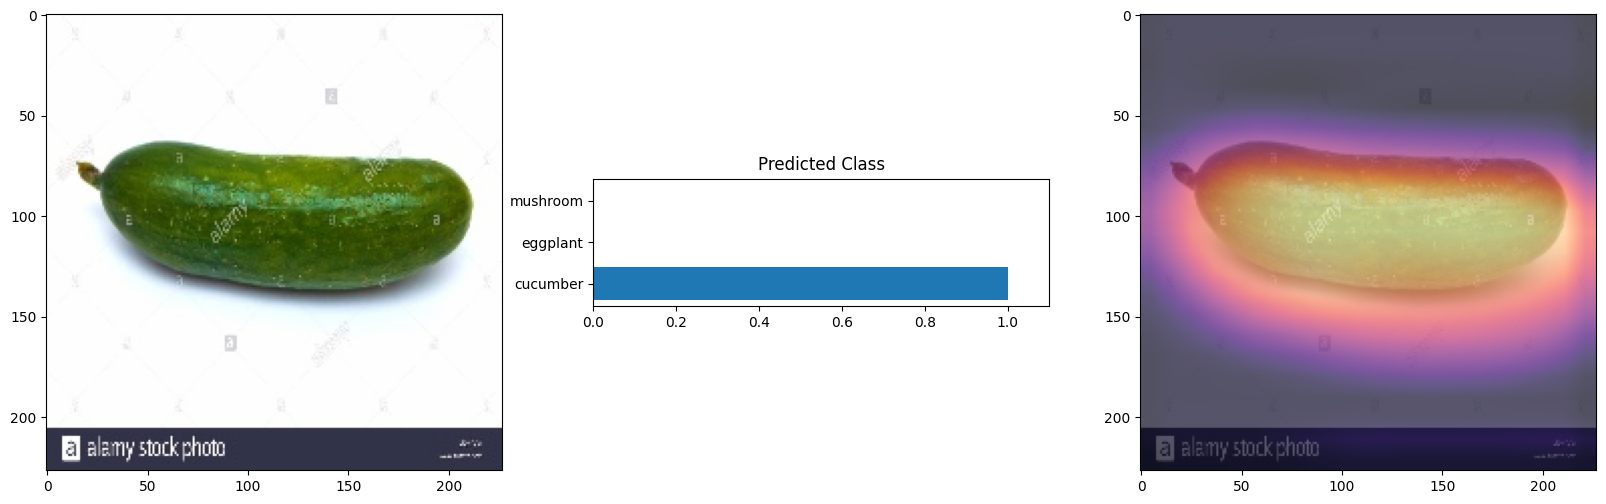

In [47]:
image, label = validset[8]

denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][0], size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)